# Exploratory Data Analysis (Assignment # 4) - Team Forever Loop

**Authors:** Santosh Ganesan, Haran Nallasivan

**Date:** 23 September 2024

## Running this notebook

TODO: add instructions for running this notebook

## Introduction

The Welltory COVID-19 and Wearables Open Data Research [1] dataset contains a wealth of data from wearables worn by participants that both had and didn't have COVID-19. A problem that we were interested in exploring was predictability of COVID-19 symptoms based on this biometeric data. For this particular analysis, we're analyzing the effect size of presence of symptoms on blood pressure. The null hypothesis is that presence of symptoms has a negligible effect on the standard deviation of the systolic and diastolic blood pressure measurements.

As a control for this analysis, we will use the group of participants that didn't report symptoms.

## Data sourcing


In [1]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path

Path('./data').mkdir(exist_ok=True)

# Helper function for extracting and persisting data
def extract_df(csv_name):
    '''
    Extracts dataframe from the data set given a CSV filename. Persists locally to avoid redudant network calls and unnecessary load on Github.

    Parameters:
        csv_name (str) - CSV filename, e.g. "blood_pressure"
    Returns:
        A pandas dataframe
    '''
    try:
        return pd.read_csv(f'./data/{csv_name}.csv')
    except:
        df = pd.read_csv(f'https://raw.githubusercontent.com/Welltory/hrv-covid19/refs/heads/master/data/{csv_name}.csv')
        df.to_csv(f'./data/{csv_name}.csv')
        return df

# Loaading the data frames
csv_names = ['blood_pressure', 'participants']
df = {}
for csv_name in csv_names:
    df[csv_name] = extract_df(csv_name)
df['blood_pressure'].head(2)

,Unnamed: 0,user_code,measurement_datetime,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index
0,0,01bad5a519,2020-04-29 22:33:33,100,150,NaN,NaN,NaN,NaN
1,1,01bad5a519,2020-04-30 01:33:33,100,150,NaN,NaN,NaN,NaN


## Questions we're asking

1. What are the dimensions of the dataset (number of rows and columns)?
1. What are the data types of the variables (numerical, categorical, text, etc.)?
1. Are there any missing values, and if so, how are they represented?

In [2]:
df['blood_pressure'].info()
print(f"Missing Values:\n{df['blood_pressure'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                721 non-null    int64  
 1   user_code                 721 non-null    object 
 2   measurement_datetime      721 non-null    object 
 3   diastolic                 721 non-null    int64  
 4   systolic                  721 non-null    int64  
 5   functional_changes_index  299 non-null    float64
 6   circulatory_efficiency    299 non-null    float64
 7   kerdo_vegetation_index    283 non-null    float64
 8   robinson_index            299 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 50.8+ KB
Missing Values:
Unnamed: 0                    0
user_code                     0
measurement_datetime          0
diastolic                     0
systolic                      0
functional_changes_index    422
circulatory_efficien

In [3]:
df['participants'].info()
print(f"Missing Values:\n{df['participants'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      185 non-null    int64  
 1   user_code       185 non-null    object 
 2   gender          185 non-null    object 
 3   age_range       185 non-null    object 
 4   city            173 non-null    object 
 5   country         179 non-null    object 
 6   height          183 non-null    float64
 7   weight          185 non-null    float64
 8   symptoms_onset  147 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 13.1+ KB
Missing Values:
Unnamed: 0         0
user_code          0
gender             0
age_range          0
city              12
country            6
height             2
weight             0
symptoms_onset    38
dtype: int64


### Interpretation
The `blood_pressure` dataframe has 721 entries of which every entry has a `user_code`, a `measurement_datetime`, a `systolic` blood pressure value, and a `diastolic` blood pressure value. There are 400+ missing values of each of the remaining columns, which we'll exclude from our analysis as we're focusing on the systolic and diastolic blood pressure data.

The `participants` dataframe has 185 entries of which every entry has a `user_code`, `gender`, `age_range`, and `weight`. There is some missing geographical information (12 missing `city` values and 6 missing `country` values) and 2 missing `height` values. There are 38 missing values for `symptoms_onset`, which could mean that either the user didn't have symptoms or failed to report symptoms. 

### Transformation to add `reported_symptoms` column to participants

Here we want to add a new column dervied from `symptoms_onset` that more clearly describes whether or not the participant reported symptoms.

In [4]:
df['participants']['reported_symptoms'] = df['participants']['symptoms_onset'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['participants'].head(3)

,Unnamed: 0,user_code,gender,age_range,city,country,height,weight,symptoms_onset,reported_symptoms
0,0,007b8190cf,m,25-34,Mandalay,Myanmar,170.18,96.162,NaN,0
1,1,013f6d3e5b,f,18-24,São Paulo,Brazil,174.00,77.300,5/15/2020,1
2,2,01bad5a519,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,1


### Transformation to add `timestamp` column to `blood_pressure`

Here we want to use the date-time strings to create a timestamp column of Pandas datetime objects.

In [5]:
df['blood_pressure']['timestamp'] = pd.to_datetime(df['blood_pressure']['measurement_datetime'])

### Adding a numeric gender column for correlation analysis

To more easily correlate our other numeric variables with gender, we're creating a `gender_index` column for which we've arbitrarily mapped `f` to 1 and `m` to 0.

In [6]:
df['participants']['gender_index'] = df['participants']['gender'].apply(lambda gender: 1 if gender == 'f' else 0)

### Joining the two datafames

We're joining the participant metadata dataframe into the blood pressure dataframe so that we can perform our analysis on a single denormalized table.

In [7]:
df['joined'] = pd.merge(df['blood_pressure'], df['participants'], on='user_code', how='left')
df['joined'].iloc[::10].head(10)

,Unnamed: 0_x,user_code,measurement_datetime,diastolic,systolic,functional_changes_index,circulatory_efficiency,kerdo_vegetation_index,robinson_index,timestamp,Unnamed: 0_y,gender,age_range,city,country,height,weight,symptoms_onset,reported_symptoms,gender_index
0,0,01bad5a519,2020-04-29 22:33:33,100,150,NaN,NaN,NaN,NaN,2020-04-29 22:33:33,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,1,0
10,10,01bad5a519,2020-05-03 21:25:34,80,120,2.92,3800.0,16.0,114.00,2020-05-03 21:25:34,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,1,0
20,20,01bad5a519,2020-05-11 20:15:55,80,118,NaN,NaN,NaN,NaN,2020-05-11 20:15:55,2,m,45-54,St Petersburg,Russia,178.00,92.000,4/5/2020,1,0
30,30,1b9321b648,2020-04-19 21:28:27,85,115,NaN,NaN,NaN,NaN,2020-04-19 21:28:27,21,f,25-34,Kamyshlov,Russia,154.00,67.000,4/11/2020,1,1
40,40,1ce1d77659,2020-05-12 14:21:59,75,121,2.45,3450.0,NaN,90.75,2020-05-12 14:21:59,22,m,25-34,Richmond Hill,United States,167.64,72.575,4/4/2020,1,0
50,50,1ed25f66e9,2020-05-21 11:18:22,80,120,NaN,NaN,NaN,NaN,2020-05-21 11:18:22,23,m,25-34,Draveil,France,176.00,82.500,3/14/2020,1,0
60,60,295ed96279,2020-01-06 09:24:51,70,110,2.10,2440.0,NaN,67.10,2020-01-06 09:24:51,34,m,35-44,Moscow,Russia,166.00,55.000,5/11/2020,1,0
70,70,295ed96279,2020-01-18 10:36:20,65,105,NaN,NaN,NaN,NaN,2020-01-18 10:36:20,34,m,35-44,Moscow,Russia,166.00,55.000,5/11/2020,1,0
80,80,425969dc69,2020-05-04 21:42:10,76,114,NaN,NaN,NaN,NaN,2020-05-04 21:42:10,51,f,35-44,London,United Kingdom,170.18,76.203,3/11/2020,1,1
90,90,6be5033971,2020-04-15 19:53:36,80,131,NaN,NaN,NaN,NaN,2020-04-15 19:53:36,81,f,45-54,Kyiv,Ukraine,164.00,58.500,3/28/2020,1,1


## Questions we're asking

1. What does this blood pressure data look like visually for users that reported symptoms versus users that didn't?
2. Are there any noticeable outliers?

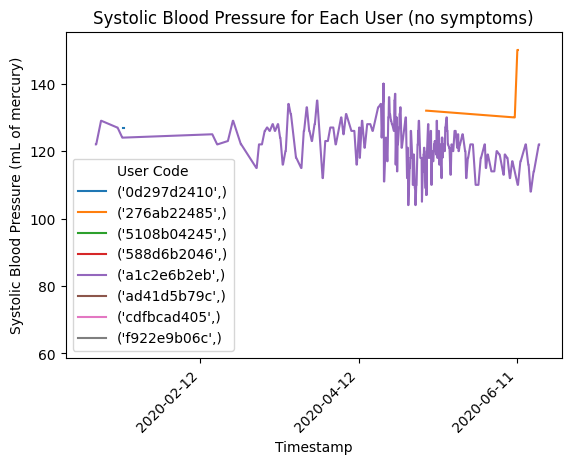

In [8]:
# Create a figure and axis
fig, ax = plt.subplots()

# Systolic blood pressure for participants who didn't report symptoms
for key, grp in df['joined'][df['joined']['reported_symptoms'] == 0].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['systolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Systolic Blood Pressure for Each User (no symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Systolic Blood Pressure (mL of mercury)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()


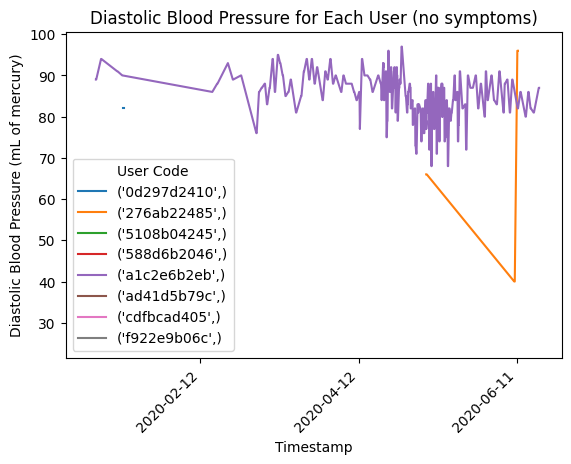

In [9]:
# Create a figure and axis
fig, ax = plt.subplots()

# Diastolic blood pressure for participants who didn't report symptoms
for key, grp in df['joined'][df['joined']['reported_symptoms'] == 0].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['diastolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Diastolic Blood Pressure for Each User (no symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Diastolic Blood Pressure (mL of mercury)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()

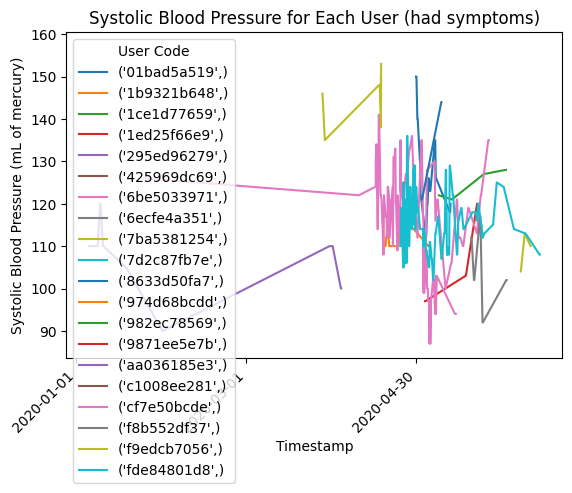

In [10]:
# Random sampling of user codes
sampled_user_codes = df['joined'][df['joined']['reported_symptoms'] == 1]['user_code'].drop_duplicates().sample(n=20, random_state=1)

# Create a figure and axis
fig, ax = plt.subplots()

# Systolic blood pressure for sampled participants who reported having symptoms
for key, grp in df['joined'][df['joined']['user_code'].isin(sampled_user_codes)].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['systolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Systolic Blood Pressure for Each User (had symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Systolic Blood Pressure (mL of mercury)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()


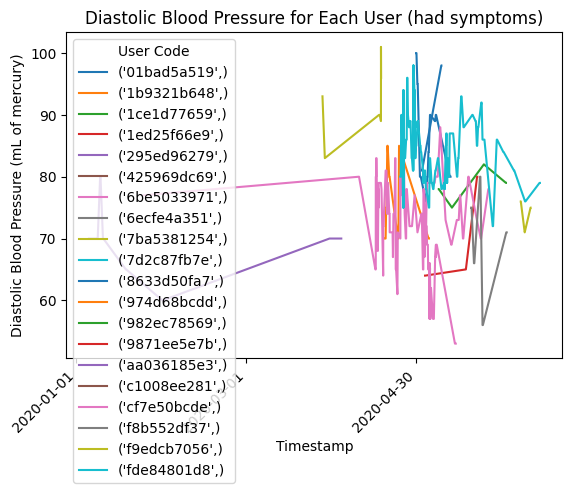

In [11]:
# Create a figure and axis
fig, ax = plt.subplots()

# Diastolic blood pressure for sampled participants who reported having symptoms
for key, grp in df['joined'][df['joined']['user_code'].isin(sampled_user_codes)].groupby(['user_code']):
    ax.plot(grp['timestamp'], grp['diastolic'], label=key)

# Format the x-axis to show dates at sensible intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add legend, title, and labels
ax.legend(title='User Code')
ax.set_title('Diastolic Blood Pressure for Each User (had symptoms)')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Diastolic Blood Pressure (mL of mercury)')

# Rotate labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()

### Interpretation

Of the participants who did not report symptoms, only one participant consistently produced blood pressure data through usage of their wearable. The other participants show sporadic usage of their wearable.

There's a similar inconsistency for the users who did report symptoms, which indicates that for our analysis, we should hone in on the users that consistently used their wearable.

## Questions we're asking

1) How do we identify missing values?
1) How are our variables correlated?
1) How should we sample the data?
1) Does this effect change after we remove outliers, duplicates, and null values?

### Identifying Missing values

To identify missing values, we will first inspect how many datapoints were logged by each user.



In [12]:
value_counts = df['joined']['user_code'].value_counts()
print("\nCount of datapoints for each user_code:\n", value_counts)



Count of datapoints for each user_code:
 user_code
a1c2e6b2eb    333
fde84801d8    128
6be5033971    105
cf7e50bcde     24
01bad5a519     23
295ed96279     22
1b9321b648     13
6ecfe4a351     10
7ba5381254      9
1ce1d77659      8
276ab22485      6
f9edcb7056      6
1ed25f66e9      6
8633d50fa7      4
0d297d2410      2
974d68bcdd      2
7d2c87fb7e      2
9871ee5e7b      2
588d6b2046      2
c1008ee281      2
f8b552df37      2
f922e9b06c      2
425969dc69      2
982ec78569      2
aa036185e3      1
ad41d5b79c      1
cdfbcad405      1
5108b04245      1
Name: count, dtype: int64


Of these users, only 3 logged more than 100 datapoints, with the rest of the users showing a sharp dropoff in the usage of their wearables. The user that logged the most datapoints was the one participant who did not report symptoms but showed consistent usage of their wearable from the previous set of plots. The other two users who logged more than 100 datapoints did report symptoms and can be seen in the previous plots despite the random sampling.

For our analysis, having a few more participants who didn't report symptoms would help to analyze the correlation between blood pressure and symptomatic COVID-19. Let us filter the above counts to just the users who didn't report symptoms.

In [13]:
value_counts = df['joined'][df['joined']['reported_symptoms'] == 0]['user_code'].value_counts()
print("\nCount of datapoints for each user_code:\n", value_counts)


Count of datapoints for each user_code:
 user_code
a1c2e6b2eb    333
276ab22485      6
0d297d2410      2
588d6b2046      2
f922e9b06c      2
5108b04245      1
ad41d5b79c      1
cdfbcad405      1
Name: count, dtype: int64


The above results aren't promising. The participant who didn't report symptoms that logged the second highest number of datapoints only logged 6. Before we proceed with any data cleanup, it would be interesting to see the correlation between our variables.

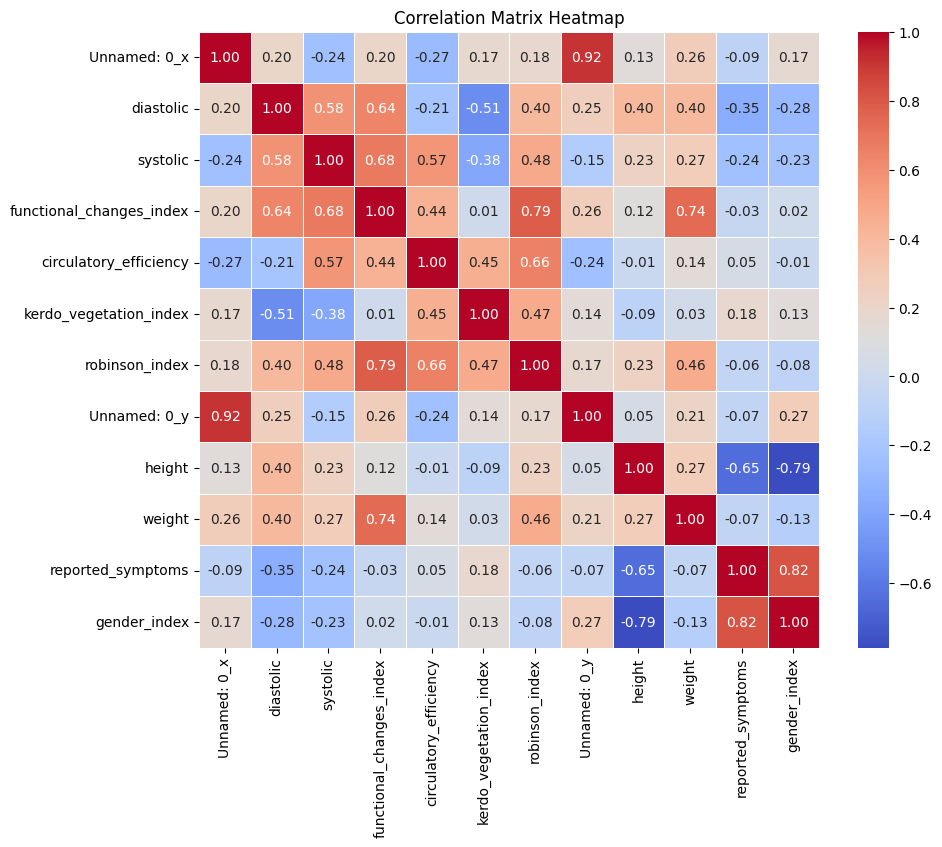

In [14]:
numeric_columns = df['joined'].select_dtypes(include=[np.number]).columns
correlation_matrix = df['joined'][numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

We can ignore the two "Unnamed" that resulted from joining the `blood_pressure` and `participants` data frames. Note that this correlation matrix was produced based on the raw timeseries data across multiple participants. 

We can see that the most correlated variables are the `functional_changes_index` with the `robinson_index`, `weight`, and the `systolic` and `diastolic` blood pressures. Height and weight are somewhat correlated with each other. Height and weight are also more correlated with diastolic blood pressure than systolic, though there's some correlation with both. 

Gender is most correlated with whether the participant reported symptoms (potential source of bias in reporting symptoms) and height, and somewhat correlated with systolic and diastolic blood pressure. 

The systolic and diastolic blood pressures are themselves correlated, and they're both correlated with the `robinson_index`. Both blood pressure readings are inversely correlated with whether the participant reported symptoms, meaning that the participants that reported symptoms tended to have lower blood pressure readings. Note that this correlation is still noticeable even though we're averaging over participants and it's evident that blood pressure is also correlated with height, weight, and gender.

### Removing Missing values

TODO: Removing time series below a predetermined threshold

In [15]:
threshold = 3
filtered_df = df['joined'][df['joined']['user_code'].map(df['joined']['user_code'].value_counts()) >= threshold]
unique_values_f = filtered_df['user_code'].unique()
value_counts_f = filtered_df['user_code'].value_counts()
print("\nCount of each unique value in 'unique_values_f' column:\n", value_counts_f)


Count of each unique value in 'unique_values_f' column:
 user_code
a1c2e6b2eb    333
fde84801d8    128
6be5033971    105
cf7e50bcde     24
01bad5a519     23
295ed96279     22
1b9321b648     13
6ecfe4a351     10
7ba5381254      9
1ce1d77659      8
1ed25f66e9      6
276ab22485      6
f9edcb7056      6
8633d50fa7      4
Name: count, dtype: int64


### Handling outliers

TODO: remove outliers identified in previous data quality section



## Reference

[1] Pravdin, Pavel (2022). *Welltory COVID-19 and Wearables Open Data Research [dataset].* 22 July 2022. Welltory Inc. CC0-1.0 License. https://github.com/Welltory/hrv-covid19